# Проект "Выбор локации для скважины"

**Описание исследования**

Имеется добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.
- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для - определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.. 


**Цель исследования**

Разработать решение, которое позволит выбрать локацию для бурения нефтяной скважины.

**Исходные данные. Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 

`/datasets/geo_data_0.csv.`

`/datasets/geo_data_1.csv.` 

`/datasets/geo_data_2.csv.`

- id — уникальный идентификатор скважины;

- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

- product — объём запасов в скважине (тыс. баррелей) - **целевой признак**.

**Условия задачи:** 

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


**Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.**


## Импорт библиотек, загрузка, чтение данных

In [1]:
!pip install -q phik

#ИЛИ
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error,
                             )
from sklearn.model_selection import train_test_split
import phik
from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Проведем импорт констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
try:
    gd_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    gd_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

gd_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
try:
    gd_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    gd_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    
gd_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
try:
    gd_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    gd_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
    
gd_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Датасет gd_0 

In [7]:
gd_0.info()
gd_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
gd_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Загрузили датасет и предварительно изучили полученные данные:

- датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации


- согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете


- была сделана описательная статистика, предварительно можно сделать выводы:

     -  имеются аномалии в столбце product - есть нулевое значение (возможно, это допускается, проверим этот момент на следующих шагах), а также наблюдаются выбросы
     - имеются выбросы в столбцах f1, f2, так как после значения 75% есть большой выброс (практически в два раза) - проверим эту информацию далее

### Датасет gd_1

In [9]:
gd_1.info()
gd_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
gd_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Загрузили датасет и предварительно изучили полученные данные:

- датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации


- согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете


- была сделана описательная статистика, предварительно можно сделать выводы:

     - имеются аномалии в столбце f0 - наблюдаются выбросы в данных (рассмотрим их подробнее на этапе исследовательского анализа)
     - высокое стандартное отклонение в столбце product, есть также нулевое значение. возможно, это всё же не аномалия и такое значение имеет место быть, если с точки не получилось собрать продукт

### Датасет gd_2

In [11]:
gd_2.info()
gd_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [12]:
gd_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Загрузили датасет и предварительно изучили полученные данные:

- датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации


- согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете


- была сделана описательная статистика, предварительно можно сделать выводы:

     - во всех столбцах датасета присутствуют выбросы (так как имеются значения 25%-75%, они соответственно образуются ящик на диагрмме ящик с усами, а вне этого ящика большие выбросы в большную и меньшую сторону), но более детально изучим это на этапе исследовательского анализа данных. а также решим, как поступить со всеми выбросами (оставить или нет)

Во всех трех датасетах названия столбцов имеют корректное наименование, переименовывать не требуется. Перейдём к следующему шагу.

### Предобработка данных

In [13]:
print('Число дублей в датафрейме gd_0:', gd_0.duplicated().sum())
print('Число дублей в датафрейме gd_1:', gd_1.duplicated().sum())
print('Число дублей в датафрейме gd_2:', gd_2.duplicated().sum())

Число дублей в датафрейме gd_0: 0
Число дублей в датафрейме gd_1: 0
Число дублей в датафрейме gd_2: 0


На данном шаге можно сделать выводы, что явные дубликаты отсутствуют. 

Так как нет столбцов с категориальными данными (все числовые, кроме id, но там нет смысла в проверке неявных дубликатов), неявные дубликаты проверять на данном шаге не будем.


**Вывод по предобработке данных**:

Можно сделать выводы, что в данных, предоставленных для анализа:

   - переименовывать столбцы не потребовалось;
    
   - пропусков нет;
    
   - все типы данных соответствуют;
    
   - дубликаты отсутствуют.
    
Эти выводы позволяют нам перейти к Исследовательскому анализу данных.

### Исследовательский анализ данных

Построим гистограммы по непрерывным количественным признакам, чтобы сопоставить с данными, полученными после описательной статистики. 

Все столбцы в данных датасетах содержат количественные непрерывные признаки, так как f0,f1,f2 и product могут принимать любые значения.

### Датасет gd_0

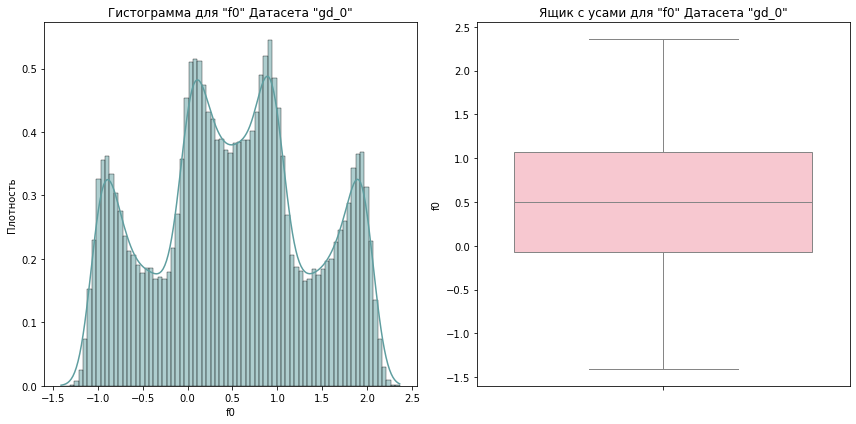

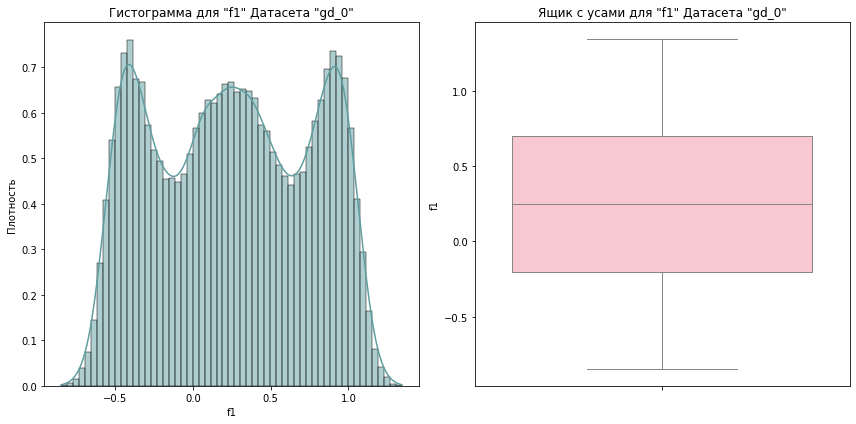

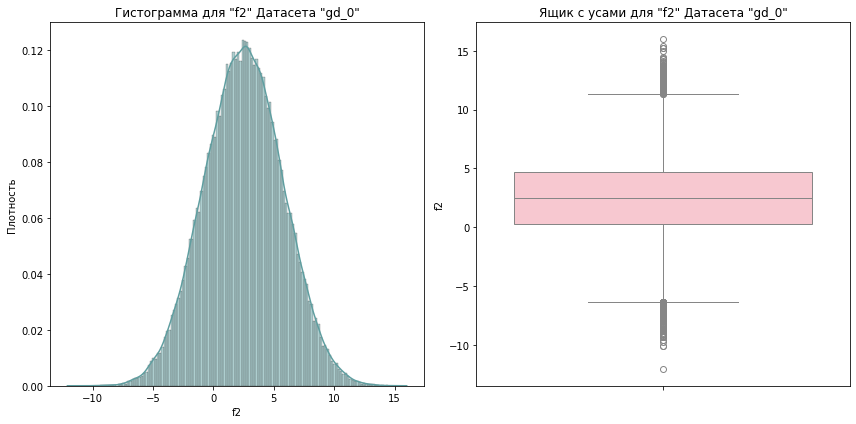

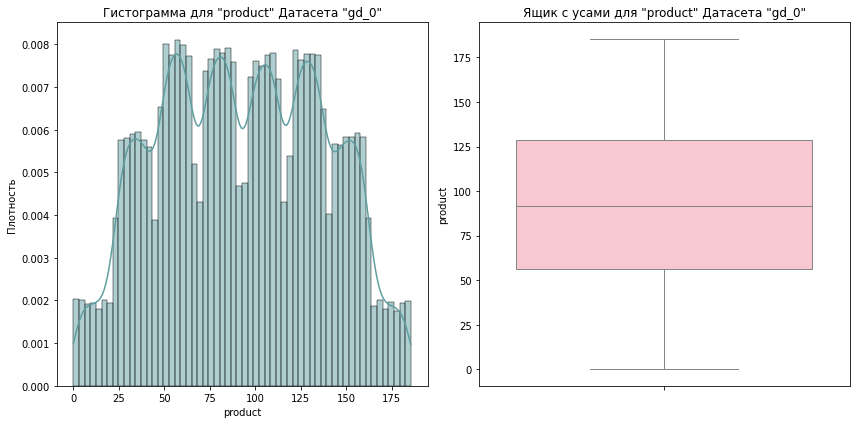

In [14]:
continuous_cols = ['f0', 'f1', 'f2', 'product']

# Для каждого столбца создаём два подграфика: гистограмма и ящик с усами
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Один ряд и два столбца
    axes[0].set_title(f'Гистограмма для "{col}" Датасета "gd_0"')
    axes[1].set_title(f'Ящик с усами для "{col}" Датасета "gd_0"')

    # Гистограмма
    sns.histplot(
        gd_0[col],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=axes[0]  
    )
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Плотность')

    # Диаграмма "ящик с усами"
    sns.boxplot(
        y=gd_0[col],
        color='pink',
        ax=axes[1]  
    )
    axes[1].set_ylabel(col)

   
    plt.tight_layout()
    plt.show()



In [15]:
gd_0 = gd_0.set_index('id')

gd_0.info()

#сделали этот шаг, чтобы не учитывать столбец id

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


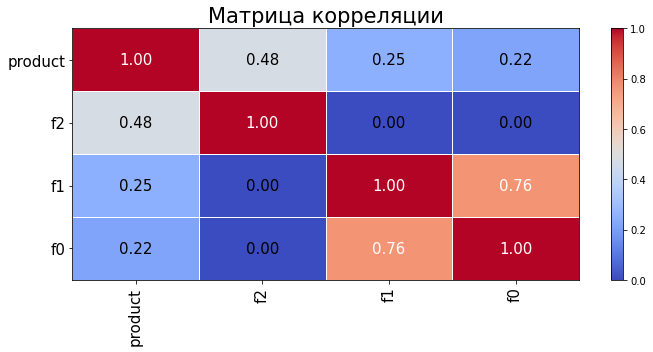

In [16]:
interval_cols = ['f0', 'f1', 'f2', 'product']

corr_matrix = phik_matrix(gd_0, interval_cols=interval_cols)


plot_correlation_matrix(
    corr_matrix.values,
    x_labels = corr_matrix.columns,
    y_labels = corr_matrix.index,
    vmin = 0, vmax = 1, color_map = 'coolwarm',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(10, 5)
)


По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) 
Для f0, f1, product можно отметить наличие нескольких пиков, что свидетельствует о мультимодальном распределении, в то время как для f2 распределение унимодальное, но судя по диаграмме ящик  с усами отмечается присутствие выбросов. Удалять их не будем.

На матрице корреляции можно отметить довольно-таки высокую корреляцию между показателем f1 и f0, но возможно это не очень информативно, так как со значением целевой переменной у столбцов особо корреляции не наблюдается.


### Датасет gd_1

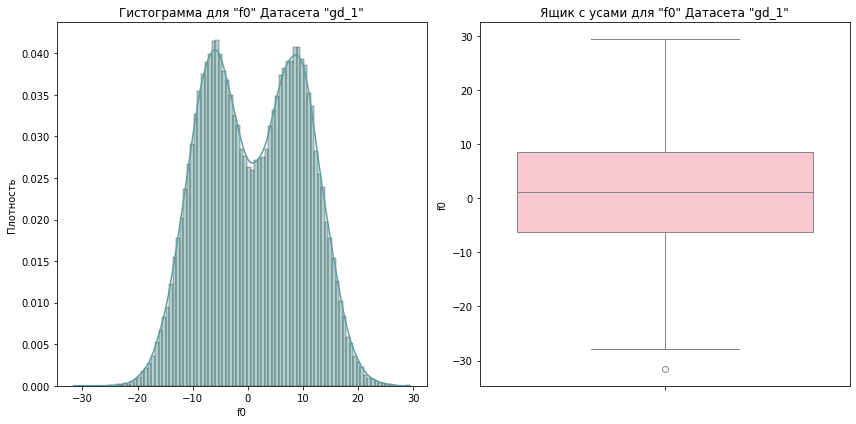

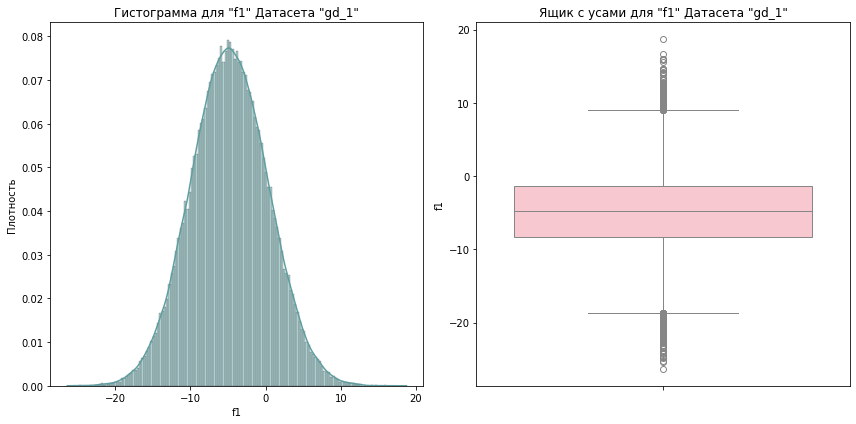

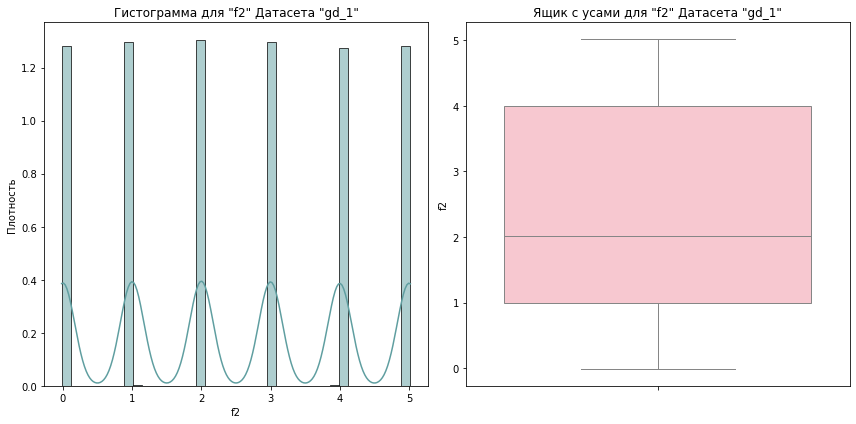

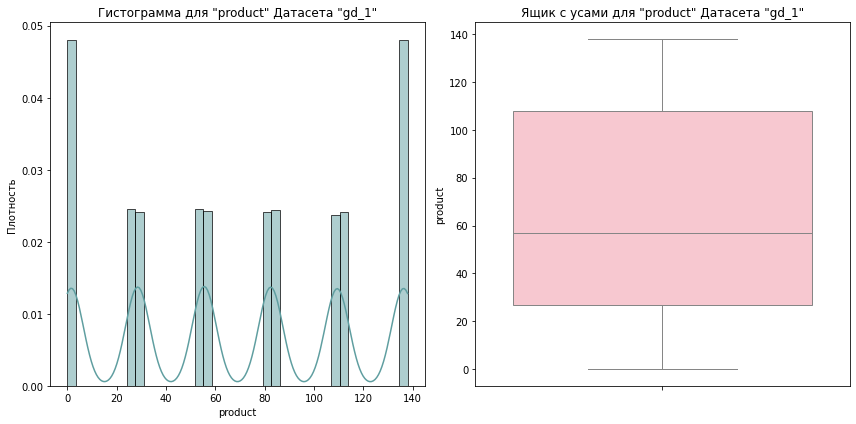

In [17]:
# Для каждого столбца создаём два подграфика: гистограмма и ящик с усами
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Один ряд и два столбца
    axes[0].set_title(f'Гистограмма для "{col}" Датасета "gd_1"')
    axes[1].set_title(f'Ящик с усами для "{col}" Датасета "gd_1"')

    # Гистограмма
    sns.histplot(
        gd_1[col],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=axes[0]  
    )
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Плотность')

    # Диаграмма "ящик с усами"
    sns.boxplot(
        y=gd_1[col],
        color='pink',
        ax=axes[1]  
    )
    axes[1].set_ylabel(col)

   
    plt.tight_layout()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


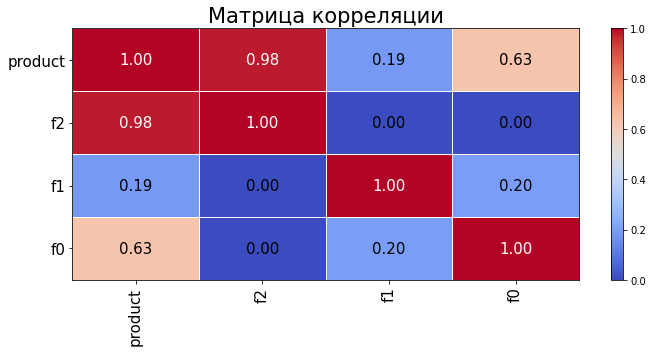

In [18]:
gd_1 = gd_1.set_index('id')

gd_1.info()

#сделали этот шаг, чтобы не учитывать столбец id

corr_matrix = phik_matrix(gd_1, interval_cols=interval_cols)


plot_correlation_matrix(
    corr_matrix.values,
    x_labels = corr_matrix.columns,
    y_labels = corr_matrix.index,
    vmin = 0, vmax = 1, color_map = 'coolwarm',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(10, 5)
)

По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) 
Для f0 - имеется два пика - бимодальное распределение, f1 - унимодальное, наблюдаются единичные выбросы и выбросы за пределами диаграммы, а для f2 и product будто бы наблюдается кластеризация.

На матрице корреляции можно отметить довольно-таки высокую корреляцию между показателем f2 и product, посмотрим далее, как это отразится на процессе исследования. А также имеется умеренная корреляция, со значением f0.


### Датасет gd_2

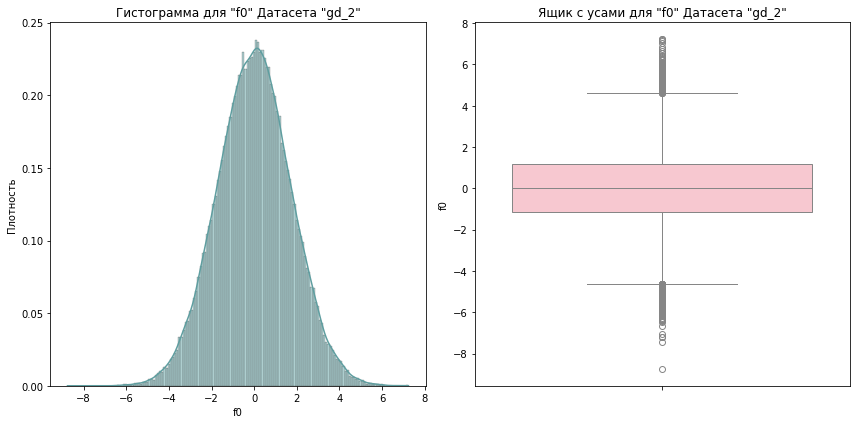

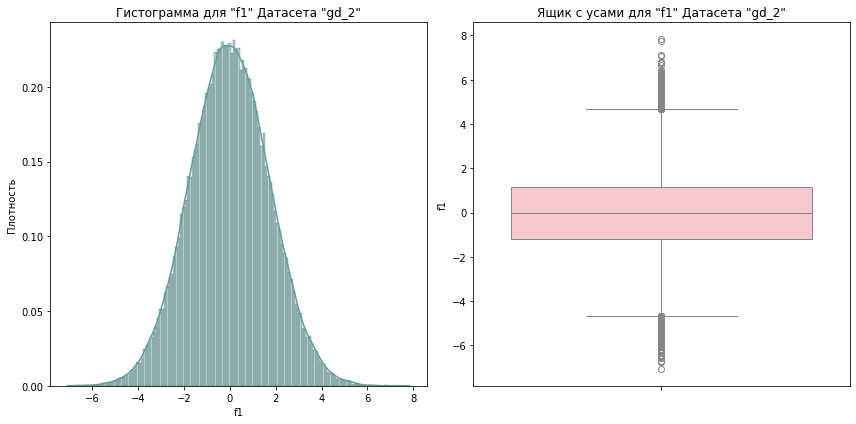

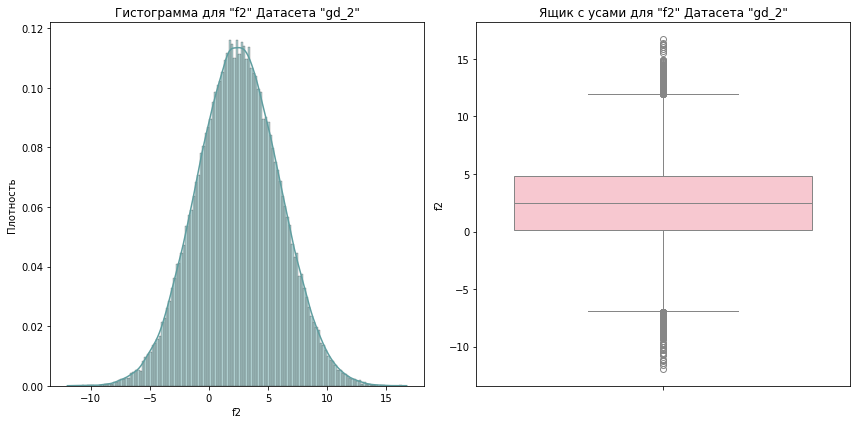

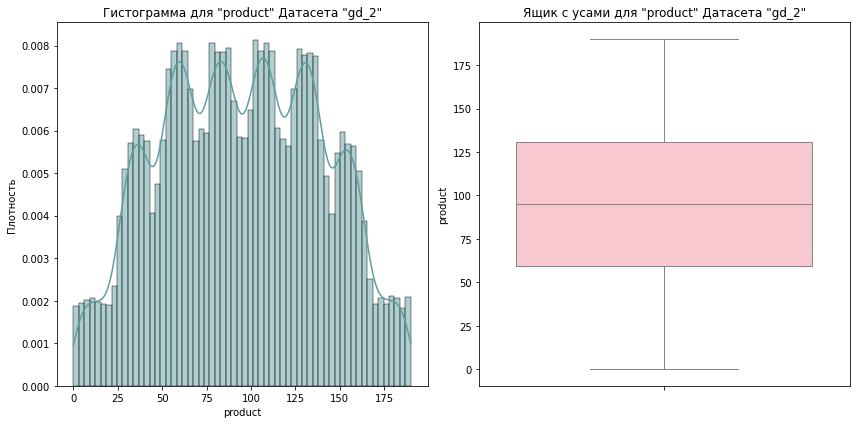

In [19]:
continuous_cols = ['f0', 'f1', 'f2', 'product']

# Для каждого столбца создаём два подграфика: гистограмма и ящик с усами
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Один ряд и два столбца
    axes[0].set_title(f'Гистограмма для "{col}" Датасета "gd_2"')
    axes[1].set_title(f'Ящик с усами для "{col}" Датасета "gd_2"')

    # Гистограмма
    sns.histplot(
        gd_2[col],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=axes[0]  
    )
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Плотность')

    # Диаграмма "ящик с усами"
    sns.boxplot(
        y=gd_2[col],
        color='pink',
        ax=axes[1]  
    )
    axes[1].set_ylabel(col)

   
    plt.tight_layout()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


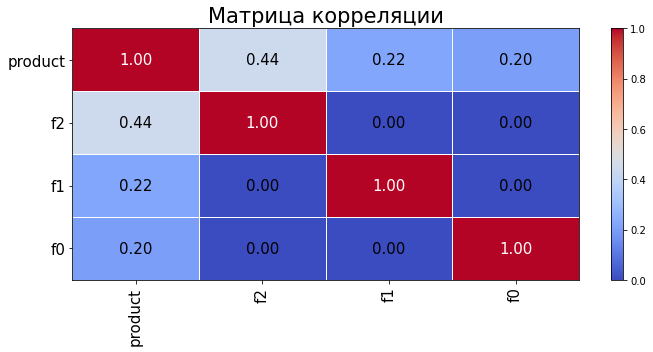

In [20]:
gd_2 = gd_2.set_index('id')

gd_2.info()

#сделали этот шаг, чтобы не учитывать столбец id

corr_matrix = phik_matrix(gd_2, interval_cols=interval_cols)


plot_correlation_matrix(
    corr_matrix.values,
    x_labels = corr_matrix.columns,
    y_labels = corr_matrix.index,
    vmin = 0, vmax = 1, color_map = 'coolwarm',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(10, 5)
)

По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) 
У данного датасета для f0, f1, f2 наблюдается унимодальное распределение. А вот у product - целевой переменной - распределение мультимодальное. Имеются выбросы, выходящие за границы ящика с усами.

Умеренной или сильной корреляции между столбцами датасета f0,f1,f2 и целевым признаком product не наблюдается.

А также для всех датасетов убрали id/

## Обучение и проверка модели

Сначала были мысли по отдельности для каждого датасета провести обучение и прогноз, но так как датасеты однообразные, то рациональнее будет определить функцию, которая проведет все необходимые операции с данными (разделение, предсказание, расчет метрик)

In [21]:
#Определим функцию
def lr_oil(df):
    X = df.drop(['product'], axis=1)  # Выделение целевого признака - 'product'
    y = df['product']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)  # Разделение выборки
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5  # Расчет метрик
    
    print("Предсказание по данным:")
    print(f"RMSE {rmse}")
    print(f"MSE  {mse}")
    print(f"Предсказанный средний запас нефти {predictions.mean()}")
    print(f"Фактический средний запас нефти {y_test.mean()}")

    
    return model, X_test, y_test, predictions


Таким образом, функция позволяет провести весь необходимый набор операций для прогнозирования, которые мы выполним далее:

### Датасет gd_0

In [22]:
model_0, X_test_0, y_test_0, predictions_0 = lr_oil(gd_0)

Предсказание по данным:
RMSE 37.75660035026169
MSE  1425.5608700093812
Предсказанный средний запас нефти 92.39879990657768
Фактический средний запас нефти 92.32595637084387


**Вывод:**

1. **Средний запас нефти**: Предсказанное значение среднего запаса нефти (92.40) очень близко к фактическому значению (92.33). 

2. **RMSE**: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 37.76, сравним с показателями остальных регионов. 

3. **MSE**: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 1425).


### Датасет gd_1

In [23]:
model_1, X_test_1, y_test_1, predictions_1 = lr_oil(gd_1)

Предсказание по данным:
RMSE 0.890280100102884
MSE  0.7925986566392013
Предсказанный средний запас нефти 68.71287803913762
Фактический средний запас нефти 68.72538074722745


**Вывод:**

1. **Средний запас нефти**: Предсказанное значение среднего запаса нефти (68,71) очень близко к фактическому значению (68,73). 

2. **RMSE**: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 0,89, что намного меньше по сравнению с предыдущим регионом, на этих данных модель практически не ошибается. 

3. **MSE**: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 0,79).

Пока показатели модели у данного региона демонстрируют лучшие значения.


### Датасет gd_2

In [24]:
model_2, X_test_2, y_test_2, predictions_2 = lr_oil(gd_2)

Предсказание по данным:
RMSE 40.145872311342174
MSE  1611.6910636385903
Предсказанный средний запас нефти 94.77102387765939
Фактический средний запас нефти 95.15099907171961


**Вывод:**

1. **Средний запас нефти**: Предсказанное значение среднего запаса нефти (94,77) также близко к фактическому значению (95,15). 

2. **RMSE**: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 40, что является самым высоким значением из трёх регионов, на этих данных модель может ошибиться на самое большое значение - 40. 

3. **MSE**: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 1611,69). 

Если сравнивать то, как отработала обученная модель на 3 датасетах:
- по показателю средний предсказанный запас нефти - лидирует 3 регион (gd_2), далее идет 1 регион (gd_0), так как у него показано наибольшее значение, однако, метрика RMSE указывает на то, что модель на данных датах ошибается довольно-таки на большое значение тыс.баррелей, потому что у этих регионов RMSE 40 и 37,76 соответственно. А значит в данных имеется неоднородность, которая может быть связана с выбросами и т.д., из-за которых точное предсказание получить сложно. Возможно, требуется получение дополнительных данных.


Поэтому, опираясь на показатели метрики RMSE можно сделать предварительный вывод, что gd_1 - 2 регион, является более перспективным, так как там средний запас нефти хоть и меньше (68,71 - предсказанный), но модель там ошибается на меньшее число тыс.баррелей. А также тут можно вспомнить, что в данном датасете наблюдалась корреляция между признаками и целевым признаком. Но нельзя и исключать и переобучение модели.  

## Подготовка к расчёту прибыли

In [25]:
#обозначим константы для данного этапа исследования.

oil_points = 500 #количество точек для нефтедобычи
top_oil_points = 200 #будут выбраны 200 лучших
provided_budg = 10000000000 #выделенный бюджет
per_barrel = 450000 #стоимость одного барреля
treshold=0.025 #пороговое значение риска

In [26]:
#Расчитаем точку безубыточности:
break_point = (provided_budg / per_barrel) / top_oil_points
print(f'Точка безубыточности соответсвует значению {break_point:.2f} тыс. баррелей.')

Точка безубыточности соответсвует значению 111.11 тыс. баррелей.


In [27]:
#для удобства сделаем цикл, который рассчитает интересующие нас показатели для каждого региона:
for i in range(3):
    dataset_name = f'gd_{i}'
    dataset = globals()[dataset_name]
    name = f'Регион {i+1}'  #Чтобы применять названия региона, хотя можно было бы и определить список.
    
    print()
    print(f'Средний запас нефти в {name} регионе = {dataset["product"].mean():.2f} тыс. баррелей.')
    print(f'% скважин, превышающих  значение точки безубыточности = \
    {len(dataset.query("product > @break_point")) / len(dataset):.2%}')
    print(f'скважин, превышающих точки безубыточности = {len(dataset.query("product > @break_point"))}')




Средний запас нефти в Регион 1 регионе = 92.50 тыс. баррелей.
% скважин, превышающих  значение точки безубыточности =     36.58%
скважин, превышающих точки безубыточности = 36583

Средний запас нефти в Регион 2 регионе = 68.83 тыс. баррелей.
% скважин, превышающих  значение точки безубыточности =     16.54%
скважин, превышающих точки безубыточности = 16537

Средний запас нефти в Регион 3 регионе = 95.00 тыс. баррелей.
% скважин, превышающих  значение точки безубыточности =     38.18%
скважин, превышающих точки безубыточности = 38178


На основании приведённых данных можно сделать следующие выводы:

1. **Средние запасы нефти**:
   -  Наибольший средний запас наблюдается в третьем регионе, затем идёт первый регион, а наименьший средний запас — во втором регионе (68.83 тыс. баррелей). Однако эти значения ниже точки безубыточности.

2. **Процент скважин, превышающих значение точки безубыточности**:
   - Первый и третий регионы демонстрируют высокий процент скважин, превышающих пороговое значение (36.58% и 38.18% соответственно). Во втором регионе этот показатель заметно ниже — 16.54%.

3. **Количество скважин, превышающих значение точки безубыточности**:
   - Абсолютное количество скважин, превышающих пороговое значение, наиболее высоко в первом регионе, затем идёт третий регион, и наименьшее количество — во втором регионе.

**Общий вывод:**
Первый и третий регионы характеризуются более высокими показателями добычи нефти. Второй регион уступает по обоим показателям. Однако прошлые этапы исследования показали, что в регионах 1 и 3 довольно-таки много выбросов. Но так как  в целом, среднее значение добычи нефти на скважине ниже, чем точка безубыточности, пока сложно рекомендовать какой-то из регионов для ведения деятельности.  

In [28]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def income(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:top_oil_points].index
    selected = target[predictions_s]
    income = selected.sum() * per_barrel - provided_budg
    return round(income, 2)

print(f'Расчёт прибыли для региона gd_0: {income(y_test_0, predictions_0):,}'.replace(',', ' '), 'руб.')
print(f'Расчёт прибыли для региона gd_1: {income(y_test_1, predictions_1):,}'.replace(',', ' '), 'руб.')
print(f'Расчёт прибыли для региона gd_2: {income(y_test_2, predictions_2):,}'.replace(',', ' '), 'руб.')

Расчёт прибыли для региона gd_0: 3 359 141 114.46 руб.
Расчёт прибыли для региона gd_1: 2 415 086 696.68 руб.
Расчёт прибыли для региона gd_2: 2 598 571 759.37 руб.


Согласно результатам расчетов, регион №1 должен принести компании больше всего прибыли - 3359141114.46 рублей.

## Расчёт прибыли и рисков 

In [29]:
def bootstrap(target, probabilities, iterations, sample_size):
    state = np.random.RandomState(12345)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(income(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2), confidence_interval, round(risk*100, 2), quantile_interval

In [30]:
gd_0_mean, gd_0_interval, gd_0_risk, gd_0_quantile = bootstrap(y_test_0.reset_index(drop=True), predictions_0, 1000,500)
print('Седняя выручка = ', gd_0_mean)
print('Регион №1 95 %ый доверительный интервал(коэф.стьюдента) = ', gd_0_interval)
print('Регион №1 95 %ый доверительный интервал(квантили) = ', gd_0_quantile)
print(f'Регион №1 Риск убытков: {gd_0_risk}%')

Седняя выручка =  406278783.42
Регион №1 95 %ый доверительный интервал(коэф.стьюдента) =  (389978382.1839447, 422579184.66477525)
Регион №1 95 %ый доверительный интервал(квантили) =  (-117742136.49274999, 911737050.7469999)
Регион №1 Риск убытков: 6.7%


In [31]:
gd_1_mean, gd_1_interval, gd_1_risk, gd_1_quantile = bootstrap(y_test_1.reset_index(drop=True), predictions_1, 1000,500)
print('Средняя выручка = ', gd_1_mean)
print('Регион №2 95 %ый доверительный интервал(коэф.стьюдента) = ',gd_1_interval)
print('Регион №2 95 %ый доверительный интервал(квантили)=', gd_1_quantile)
print(f'Регион №2 Риск убытков: {gd_1_risk}%')

Средняя выручка =  432624131.81
Регион №2 95 %ый доверительный интервал(коэф.стьюдента) =  (420008021.9836902, 445240241.64258987)
Регион №2 95 %ый доверительный интервал(квантили)= (16846174.93425, 815972526.28625)
Регион №2 Риск убытков: 1.9%


In [32]:
gd_2_mean, gd_2_interval, gd_2_risk, gd_2_quantile = bootstrap(y_test_2.reset_index(drop=True), predictions_2, 1000,500)
print('Средняя выручка = ', gd_2_mean)
print('Регион №3 95 %ый доверительный интервал(коэф.стьюдента) = ', gd_2_interval)
print('Регион №3 95 %ый доверительный интервал(квантили) = ', gd_2_quantile)
print(f'Регион №3 Риск убытков: {gd_2_risk}%')

Средняя выручка =  377362192.42
Регион №3 95 %ый доверительный интервал(коэф.стьюдента) =  (360616369.5067713, 394108015.3391286)
Регион №3 95 %ый доверительный интервал(квантили) =  (-170780417.70424998, 901772131.3885)
Регион №3 Риск убытков: 7.4%


Таким образом, можно сделать вывод, что самым лучшим вложением бюджета будет нефтедобыча в регионе №2, а именно:

- для данного региона данные более однородные, вследствие этого модель линейной регрессии допускает совсем небольшие погрешности (вывод был сделан на основании метрики RMSE, которая получилась равной 0,89 (когда у других 37 и 40, что говорит о больших ошибках, а так как решается то, куда вложить средства, такие ошибки недопустимы)

- и по данным Bootstrap регион №2 показал наилучшие показатели:

а) значение средней выручки больше, чем у регионов №1 и №3

б) наименьший риск убытков (ниже порогового значения, в то время как у регионов №1 и №3 риски превышены более, чем в 2 раза)

Что позволяет рекомендовать компании проводить нефтедобычу именно в данном регионе.

## Общий вывод по проекту


Загрузили датасет  gd_0 и предварительно изучили полученные данные:

•	датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации

•	согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете

•	была сделана описательная статистика, предварительно можно сделать выводы:

	имеются аномалии в столбце product - есть нулевое значение (возможно, это допускается, проверим этот момент на следующих шагах), а также наблюдаются выбросы

	имеются выбросы в столбцах f1, f2, так как после значения 75% есть большой выброс (практически в два раза) - проверим эту информацию далее

Загрузили датасет gd_1 и предварительно изучили полученные данные:

•	датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации

•	согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете
•	была сделана описательная статистика, предварительно можно сделать выводы:
	имеются аномалии в столбце f0 - наблюдаются выбросы в данных (рассмотрим их подробнее на этапе исследовательского анализа)

	высокое стандартное отклонение в столбце product, есть также нулевое значение. возможно, это всё же не аномалия и такое значение имеет место быть, если с точки не получилось собрать продукт

Загрузили датасет gd_2 и предварительно изучили полученные данные:

•	датасет имеет 100 000 записей и содержит в себе данные о количестве продукта, который получают с данной локации

•	согласно полученным данным, датасет не имеет пропусков, все типы данных соответствуют данным, которые содержатся в датасете

•	была сделана описательная статистика, предварительно можно сделать выводы:

	во всех столбцах датасета присутствуют выбросы (так как имеются значения 25%-75%, они соответственно образуются ящик на диагрмме ящик с усами, а вне этого ящика большие выбросы в большную и меньшую сторону), но более детально изучим это на этапе исследовательского анализа данных. а также решим, как поступить со всеми выбросами (оставить или нет)


**Вывод по предобработке данных:**


•	переименовывать столбцы не потребовалось;

•	пропусков нет;

•	все типы данных соответствуют;

•	дубликаты отсутствуют.


Построили гистограммы по непрерывным количественным признакам, чтобы сопоставить с данными, полученными после описательной статистики.

Все столбцы в данных датасетах содержат количественные непрерывные признаки, так как f0,f1,f2 и product могут принимать любые значения.

**gd_0**

По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) Для f0, f1, product можно отметить наличие нескольких пиков, что свидетельствует о мультимодальном распределении, в то время как для f2 распределение унимодальное, но судя по диаграмме ящик с усами отмечается присутствие выбросов. Удалять их не будем.
На матрице корреляции можно отметить довольно-таки высокую корреляцию между показателем f1 и f0, но возможно это не очень информативно, так как со значением целевой переменной у столбцов особо корреляции не наблюдается.

**gd_1**

По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) Для f0 - имеется два пика - бимодальное распределение, f1 - унимодальное, наблюдаются единичные выбросы и выбросы за пределами диаграммы, а для f2 и product будто бы наблюдается кластеризация.
На матрице корреляции можно отметить довольно-таки высокую корреляцию между показателем f2 и product, посмотрим далее, как это отразится на процессе исследования. А также имеется умеренная корреляция, со значением f0.

**gd_2**

По исследовательскому анализу можно сделать вывод, что в принципе данные распределены равномерно (нет смещений, наблюдается симметрия) У данного датасета для f0, f1, f2 наблюдается унимодальное распределение. А вот у product - целевой переменной - распределение мультимодальное. Имеются выбросы, выходящие за границы ящика с усами.
Умеренной или сильной корреляции между столбцами датасета f0,f1,f2 и целевым признаком product не наблюдается.
А также для всех датасетов убрали id.

Разработали функцию, которая проводит подготовку (обучение), предсказывает и рассчитывает метрики для модели линейной регрессии, что позволяет оптимизировать процесс получения предсказаний.

Вывод gd_0:

1.	Средний запас нефти: Предсказанное значение среднего запаса нефти (92.40) очень близко к фактическому значению (92.33).
2.	RMSE: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 37.76, сравним с показателями остальных регионов.
3.	MSE: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 1425).

Вывод gd_1:

1.	Средний запас нефти: Предсказанное значение среднего запаса нефти (92.40) очень близко к фактическому значению (92.33).
2.	RMSE: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 37.76, сравним с показателями остальных регионов.
3.	MSE: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 1425).

Вывод gd_2:

1.	Средний запас нефти: Предсказанное значение среднего запаса нефти (94,77) также близко к фактическому значению (95,15).
2.	RMSE: чем меньше значение RMSE, тем меньше то значение, на которое ошибается модель, в данном случае результат 40, что является самым высоким значением из трёх регионов, на этих данных модель может ошибиться на самое большое значение - 40.
3.	MSE: также говорит о возможных ошибках в прогнозе модели (точнее о средних значениях этой ошибки - в данном случае 1611,69).

Если сравнивать то, как отработала обученная модель на 3 датасетах:

•	по показателю средний предсказанный запас нефти - лидирует 3 регион (gd_2), далее идет 1 регион (gd_0), так как у него показано наибольшее значение, однако, метрика RMSE указывает на то, что модель на данных датах ошибается довольно-таки на большое значение тыс.баррелей, потому что у этих регионов RMSE 40 и 37,76 соответственно. А значит в данных имеется неоднородность, которая может быть связана с выбросами и т.д., из-за которых точное предсказание получить сложно. Возможно, требуется получение дополнительных данных.
Поэтому, опираясь на показатели метрики RMSE можно сделать предварительный вывод, что gd_1 - 2 регион, является более перспективным, так как там средний запас нефти хоть и меньше (68,71 - предсказанный), но модель там ошибается на меньшее число тыс.баррелей. А также тут можно вспомнить, что в данном датасете наблюдалась корреляция между признаками и целевым признаком. Но нельзя и исключать и переобучение модели.


На основании приведённых данных можно сделать следующие выводы:

1.	Средние запасы нефти:

•	Наибольший средний запас наблюдается в третьем регионе, затем идёт первый регион, а наименьший средний запас — во втором регионе (68.83 тыс. баррелей). Однако эти значения ниже точки безубыточности.
2.	Процент скважин, превышающих значение точки безубыточности:
•	Первый и третий регионы демонстрируют высокий процент скважин, превышающих пороговое значение (36.58% и 38.18% соответственно). Во втором регионе этот показатель заметно ниже — 16.54%.
3.	Количество скважин, превышающих значение точки безубыточности:
•	Абсолютное количество скважин, превышающих пороговое значение, наиболее высоко в первом регионе, затем идёт третий регион, и наименьшее количество — во втором регионе.
Общий вывод: Первый и третий регионы характеризуются более высокими показателями добычи нефти. Второй регион уступает по обоим показателям. Однако прошлые этапы исследования показали, что в регионах 1 и 3 довольно-таки много выбросов. Но так как в целом, среднее значение добычи нефти на скважине ниже, чем точка безубыточности, пока сложно рекомендовать какой-то из регионов для ведения деятельности.

Согласно результатам расчетов, регион №1 должен принести компании больше всего прибыли - 3359141114.46 рублей.

Таким образом, можно сделать вывод, что самым лучшим вложением бюджета будет нефтедобыча в регионе №2, а именно:
•	для данного региона данные более однородные, вследствие этого модель линейной регрессии допускает совсем небольшие погрешности (вывод был сделан на основании метрики RMSE, которая получилась равной 0,89 (когда у других 37 и 40, что говорит о больших ошибках, а так как решается то, куда вложить средства, такие ошибки недопустимы)
•	и по данным Bootstrap регион №2 показал наилучшие показатели:
а) значение средней выручки больше, чем у регионов №1 и №3
б) наименьший риск убытков
Что позволяет рекомендовать компании проводить нефтедобычу именно в данном регионе.


